In [123]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [124]:
data = pd.read_csv('diabetes.csv')

In [125]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [126]:
# normalisasi (statistik) agar mudah dicompare
column_normalize = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
data[column_normalize] = data[column_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,50,1
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,31,0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,32,1
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,21,0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,33,1


<Axes: >

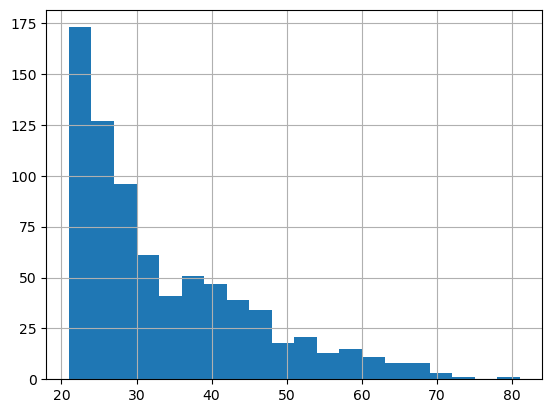

In [127]:
# cuma untuk print grafik
%matplotlib inline
data['Age'].hist(bins=20)

In [129]:
x_data = data.drop('Outcome', axis=1) # ngambil tabel data tapi tanpa kolom outcome
y_data = data['Outcome'] # ngambil tabel data cuma yang kolom outcome
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=101) # dibagi 80-20% untuk train dan test

# ngambil data dari tiap tiap kolom biar nanti waktu feat cols ngga kepanjangan
pregnant = tf.feature_column.numeric_column('Pregnancies')
glucose = tf.feature_column.numeric_column('Glucose')
bloodPressure = tf.feature_column.numeric_column('BloodPressure')
skinThickness = tf.feature_column.numeric_column('SkinThickness')
insulin = tf.feature_column.numeric_column('Insulin')
bmi = tf.feature_column.numeric_column('BMI')
pedigree = tf.feature_column.numeric_column('DiabetesPedigreeFunction')
age = tf.feature_column.numeric_column('Age')

# untuk mengkategorikan umur, jadi misal ada orang umur 35 tahun mreka masuk ke kategori umur 30-40 an
# masih blom tau alasannya kenapa, bisa jadi karena diabetes bukan linear dengan umur, tetapi resiko meningkat ketika masuk threshold tertentu?
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[20, 30, 40, 50, 60, 70, 80])

feat_cols = [pregnant, glucose, bloodPressure, skinThickness, insulin, bmi, pedigree, age_buckets]

In [130]:
# menentukan resep perlu apa aja
model = tf.estimator.LinearClassifier(feature_columns=feat_cols, n_classes=2)

# mempersiapkan data, seperti shuffle untuk mengacak, batch untuk mengelompokkan 10-10, dan jumlah pengulangan
input_func_train = lambda: (
    tf.data.Dataset.from_tensor_slices((dict(x_train), y_train))
    .shuffle(buffer_size=len(x_train))
    .batch(batch_size=10)
    .repeat(count=500)
)
#input_func = tf.estimator.inputs.pandas_input_fn(x=x_train, y=y_train, batch_size=10, num_epochs=1000, shuffle=True)    / tensorflow ver lama gabisa dipakai?

# assign weight dengan mengulang ulang (training)
model.train(input_fn=input_func_train, steps=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ASUS\\AppData\\Local\\Temp\\tmpicdw7pzs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorfl

In [131]:
pred_input_func = lambda: tf.data.Dataset.from_tensor_slices(dict(x_test)).batch(10)
predictions = model.predict(pred_input_func)
list(predictions)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ASUS\AppData\Local\Temp\tmpicdw7pzs\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'logits': array([0.21381521], dtype=float32),
  'logistic': array([0.5532511], dtype=float32),
  'probabilities': array([0.4467489, 0.5532511], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1]),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([0.6130662], dtype=float32),
  'logistic': array([0.6486399], dtype=float32),
  'probabilities': array([0.35136005, 0.6486399 ], dtype=float32),
  'class_ids': array([1], dtype=int64),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1]),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-0.21314466], dtype=float32),
  'logistic': array([0.44691467], dtype=float32),
  'probabilities': array([0.5530854 , 0.44691467], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1]),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {

In [132]:
eval_input_func = lambda: tf.data.Dataset.from_tensor_slices((dict(x_test), y_test)).batch(10)
results = model.evaluate(eval_input_func)
results

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2024-01-12T09:48:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ASUS\AppData\Local\Temp\tmpicdw7pzs\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.64090s
INFO:tensorflow:Finished evaluation at 2024-01-12-09:48:11
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.72440946, accuracy_baseline = 0.6574803, auc = 0.78580767, auc_precision_recall = 0.63553673, average_loss = 0.5363116, global_step = 1000, label/mean = 0.34251967, loss = 0.5426352, precision = 0.6, prediction/mean = 0.3848899, recall = 0.5862069
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: C:\Users\ASUS\AppData\Local\Temp\tmpicdw7pzs\model.ckpt-1000


{'accuracy': 0.72440946,
 'accuracy_baseline': 0.6574803,
 'auc': 0.78580767,
 'auc_precision_recall': 0.63553673,
 'average_loss': 0.5363116,
 'label/mean': 0.34251967,
 'loss': 0.5426352,
 'precision': 0.6,
 'prediction/mean': 0.3848899,
 'recall': 0.5862069,
 'global_step': 1000}